In [1]:
import sys
import pandas as pd
from sklearn.metrics import cohen_kappa_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import sys
sys.path.append('../modules')
from sklearn.metrics import cohen_kappa_score, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from krippendorff import alpha as krippendorff_alpha
import matplotlib.pyplot as plt
import seaborn as sns
from seeDistinctValues import seeDistinctValues
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
import numpy as np

from collections import Counter


df = pd.read_csv('merged_checked.csv')

# Funzioni

## Funzione classica per il calcolo del Kappa


In [2]:
def inter_annotator_agreement(df, column_name, annotator1, annotator2):
    # Filter rows for the given annotators
    df_annotator1 = df[df['annotator'] == annotator1]
    df_annotator2 = df[df['annotator'] == annotator2]
    
    # Merge dataframes on the ID column
    merged_df = df_annotator1.merge(df_annotator2, on='id')
    
    # Filter rows with non-missing values for the given column
    merged_df = merged_df.dropna(subset=[column_name+'_x', column_name+'_y'])

    # Rimuovo le righe vuote dal dataset degli annotatori, vanno bene le righe perché tanto c'è un valore solo
    merged_df = merged_df[merged_df[column_name+'_x'] != -1]
    merged_df = merged_df[merged_df[column_name+'_x'] != '-1']
    merged_df = merged_df[merged_df[column_name+'_y'] != -1]
    merged_df = merged_df[merged_df[column_name+'_y'] != '-1']
    
    agreement_score = cohen_kappa_score(merged_df[column_name+'_x'], merged_df[column_name+'_y'])
    
    print('Kappa tra ' + annotator1 + ' e ' + annotator2 + ' per ' + column_name + ': ' + str(agreement_score))




## Funzione per le metriche standard (balanced accuracy)

In [3]:
def calculate_standard_metrics(annotator_1, annotator_2, df):
    filtered_df = df[df['annotator'].isin([annotator_1, annotator_2])]
    ids_annotator_1 = filtered_df[filtered_df['annotator'] == annotator_1]['id']
    ids_annotator_2 = filtered_df[filtered_df['annotator'] == annotator_2]['id']
    common_ids = ids_annotator_1[ids_annotator_1.isin(ids_annotator_2)]
    df = filtered_df[filtered_df['id'].isin(common_ids)]

    gpt_df = df[df['annotator'] == annotator_2]
    human_df = df[df['annotator'] == annotator_1]

    results = {}

    merged_data = pd.merge(gpt_df, human_df, on="id", suffixes=("_gpt", "_human"))

    columns_of_interest = df.drop(columns=['id', 'annotator']).columns.tolist()

    plt.subplots_adjust(top=10)

    for col in columns_of_interest:
        y_gpt = merged_data[col + "_gpt"]
        y_human = merged_data[col + "_human"]

        # Filter out cases where either annotator has value -1
        valid_indices = (y_gpt != -1) & (y_human != -1)
        y_gpt = y_gpt[valid_indices]
        y_human = y_human[valid_indices]

        if len(y_gpt) == 0:
            continue  # Skip this column if there are no valid annotations
        
        # Baseline "most_frequent" (as you already have)
        baseline_model_most_frequent = DummyClassifier(strategy="most_frequent")
        # Filtering human_df based on the IDs present in merged_data with valid indices
        baseline_model_most_frequent.fit(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]], y_human)
        y_pred_baseline_most_frequent = baseline_model_most_frequent.predict(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]])

        # Baseline "stratified"
        baseline_model_stratified = DummyClassifier(strategy="stratified")
        # Same filtering for stratified baseline model
        baseline_model_stratified.fit(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]], y_human)
        y_pred_baseline_stratified = baseline_model_stratified.predict(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]])

        balanced_acc = balanced_accuracy_score(y_human, y_gpt)
        f1_micro = f1_score(y_human, y_gpt, average='micro')
        f1_macro = f1_score(y_human, y_gpt, average='macro')
        f1_avg = f1_score(y_human, y_gpt, average='weighted')

        balanced_acc_baseline_most_frequent = balanced_accuracy_score(y_human, y_pred_baseline_most_frequent)
        f1_micro_baseline_most_frequent = f1_score(y_human, y_pred_baseline_most_frequent, average='micro')
        f1_macro_baseline_most_frequent = f1_score(y_human, y_pred_baseline_most_frequent, average='macro')
        f1_avg_baseline_most_frequent = f1_score(y_human, y_pred_baseline_most_frequent, average='weighted')

        balanced_acc_baseline_stratified = balanced_accuracy_score(y_human, y_pred_baseline_stratified)
        f1_micro_baseline_stratified = f1_score(y_human, y_pred_baseline_stratified, average='micro')
        f1_macro_baseline_stratified = f1_score(y_human, y_pred_baseline_stratified, average='macro')
        f1_avg_baseline_stratified = f1_score(y_human, y_pred_baseline_stratified, average='weighted')

        results[col] = {
            'balanced_accuracy': balanced_acc,
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'f1_avg': f1_avg,
            'baseline_most_frequent_balanced_accuracy': balanced_acc_baseline_most_frequent,
            'baseline_most_frequent_f1_micro': f1_micro_baseline_most_frequent,
            'baseline_most_frequent_f1_macro': f1_macro_baseline_most_frequent,
            'baseline_most_frequent_f1_avg': f1_avg_baseline_most_frequent,
            'baseline_stratified_balanced_accuracy': balanced_acc_baseline_stratified,
            'baseline_stratified_f1_micro': f1_micro_baseline_stratified,
            'baseline_stratified_f1_macro': f1_macro_baseline_stratified,
            'baseline_stratified_f1_avg': f1_avg_baseline_stratified
        }
    num_cols = len(columns_of_interest)
    num_plots_per_row = 3
    num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

    fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(18, 4*num_rows))

    for i, col in enumerate(columns_of_interest):
        metrics = results[col]

        labels = ['Bal. Accuracy', 'F1 Micro', 'F1 Macro', 'F1 Weighted']
        model_values = [metrics['balanced_accuracy'], metrics['f1_micro'], metrics['f1_macro'], metrics['f1_avg']]
        baseline_values_most_frequent = [metrics['baseline_most_frequent_balanced_accuracy'], metrics['baseline_most_frequent_f1_micro'],
                                         metrics['baseline_most_frequent_f1_macro'], metrics['baseline_most_frequent_f1_avg']]
        baseline_values_stratified = [metrics['baseline_stratified_balanced_accuracy'], metrics['baseline_stratified_f1_micro'],
                                      metrics['baseline_stratified_f1_macro'], metrics['baseline_stratified_f1_avg']]

        row_idx = i // num_plots_per_row
        col_idx = i % num_plots_per_row

        x = np.arange(len(labels))
        width = 0.25

        axs[row_idx, col_idx].bar(x - width, model_values, width, label='Model')
        axs[row_idx, col_idx].bar(x, baseline_values_most_frequent, width, label='Baseline (most frequent)')
        axs[row_idx, col_idx].bar(x + width, baseline_values_stratified, width, label='Baseline (stratified)')

        for j, (v, b1, b2) in enumerate(zip(model_values, baseline_values_most_frequent, baseline_values_stratified)):
            offset = 0
            axs[row_idx, col_idx].text(x[j] - width + offset, v + 0.01, f"{v:.4f}", ha='center', fontsize=7)
            axs[row_idx, col_idx].text(x[j], b1 + 0.01, f"{b1:.4f}", ha='center', fontsize=7)
            axs[row_idx, col_idx].text(x[j] + width + offset, b2 + 0.01, f"{b2:.4f}", ha='center', fontsize=7)

        axs[row_idx, col_idx].set_ylabel('Score')
        axs[row_idx, col_idx].set_title(f'Metrics for {col}')
        axs[row_idx, col_idx].set_xticks(x)
        axs[row_idx, col_idx].set_xticklabels(labels)
        axs[row_idx, col_idx].legend()
        axs[row_idx, col_idx].set_ylim(0, 1.07)

    for i in range(num_rows * num_plots_per_row):
        if i >= num_cols:
            axs.flatten()[i].axis('off')

    plt.tight_layout()
    plt.show()

## Confusion Matrix

In [4]:
def calculate_confusion_matrix(annotator_1, annotator_2, columns, possible_values):
    confusion_matrices = {}
    for column in columns:
        y_true = []
        y_pred = []

        articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
            set(df[df['annotator'] == annotator_2]['id']))

        for article_id in articles:
            annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][[column]]
            annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][[column]]

            annotator1 = annotator1.astype(str)
            annotator2 = annotator2.astype(str)

            for col in annotator1.columns:
                annotations_1 = annotator1[col].values.flatten()
                annotations_2 = annotator2[col].values.flatten()
                for ann_1, ann_2 in zip(annotations_1, annotations_2):
                    y_true.append(ann_1)
                    y_pred.append(ann_2)

        confusion_matrices[column] = confusion_matrix(y_true, y_pred, labels=possible_values[column])
    plot_confusion_matrices(confusion_matrices, possible_values)
    return 0

def plot_confusion_matrices(conf_matrices, possible_values):
    num_cols = len(conf_matrices)
    num_rows = int(np.ceil(num_cols / 4))
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

    for i, (column, conf_matrix) in enumerate(conf_matrices.items()):
        row = i // 4
        col = i % 4
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[row, col], 
                    xticklabels=possible_values[column], yticklabels=possible_values[column])
        axes[row, col].set_xlabel("Predicted labels")
        axes[row, col].set_ylabel("True labels")
        axes[row, col].set_title(f"Confusion Matrix for Column '{column}'")

    plt.tight_layout()
    plt.show()


columns_to_consider = ["Q1.2", "Q1.3.1", "Q1.4", "Q1.5", "Q1.6", "Q1.7"]
possible_values = {
    'Q1.2': ['1', '2', '3', '4'],
    'Q1.3.1': ['1', '2'],
    'Q1.4': ['1', '2'],
    'Q1.5': ['1', '2', '3', '4'],
    'Q1.6': ['1', '2', '3', '4'],
    'Q1.7': ['1', '2'],
}

# Q 1.1 

## Questions

### Original

Q1.1: What type of news article are you reviewing? (Check one): <br>
    1.  Straight news, or 'hard news' <br>
    2.  Editorial/opinion <br>
    3.  Feature/investigation <br>
    4.  Satire <br>
    5.  Lifestyle content, obituary, 'listicle', or other 'soft news' <br>


### Revisited

Step 2  - Is this article Straight news or 'hard news'?(if the article reports essential information in a concise and impartial manner,  the information should be based on facts, and there should be no personal opinion of the author)
    1.  No
    2.  Yes

Step 3 - Is this article an Editorial/opinion?(if the article communicates the author’s personal point of view about current events and topics in order to develop an argument about an issue and potentially sway readers’ opinions.​​ Opinion pieces include editorials, op-eds, commentary, analysis, and letters to the editor.)    
    1.  No
    2.  Yes

Step 4 - Is this article a Feature/investigation? (if the article contains at least one of the following elements: in-depth coverage, rich storytelling, and investigative elements)
    1.  No
    2.  Yes

Step 5 - Is this article a  Satire?
    1.  No
    2.  Yes

Step 6  - Is this article Lifestyle content, obituary, 'listicle,' or other 'soft news' or gossip? 
    1.  No
    2.  Yes



## Analisi

In [5]:
df['Q1.1']

0       2;1;1;1;1
1       2;1;1;1;1
2       2;1;1;1;1
3       2;1;1;1;1
4       1;2;1;1;1
          ...    
1014    2;1;2;1;1
1015    1;1;2;1;1
1016    2;1;2;1;1
1017    1;2;2;1;1
1018    1;2;1;1;1
Name: Q1.1, Length: 1019, dtype: object

### K

In [6]:
inter_annotator_agreement(df, 'Q1.1', 'Manuel', 'Angelo')
inter_annotator_agreement(df, 'Q1.1', 'Manuel', 'Marinella')
inter_annotator_agreement(df, 'Q1.1', 'Angelo', 'Marinella')
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.1', 'Manuel', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.1', 'Marinella', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.1', 'Angelo', 'ChatGPT4AsAnnotator')


Kappa tra Manuel e Angelo per Q1.1: 0.6903472443453329
Kappa tra Manuel e Marinella per Q1.1: 0.7307060755336616
Kappa tra Angelo e Marinella per Q1.1: 0.8258518117901569
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.1: 0.19536670997705474
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.1: 0.19281271596406346
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.1: 0.2234433608402101


### Vedo dove e come sbaglia

In [7]:

def custom_agreement(column_name,set1, set2):

    # Split the numbers
    set1 = set1.split(";")
    set2 = set2.split(";")

    # Verifica se entrambe le liste contengono almeno un 2
    if '2' in set1 and '2' in set2:
        # Verifica se i 2 sono nella stessa posizione
        if set1 == set2:
            return "Perfect Agreement (All correct)"
        # Verifica se nella seconda lista c'è almeno un 2 nella stessa posizione
        elif any(a == b == '2' for a, b in zip(set1, set2)):
            #print ('lista 1' +str(set1) + ' lista 2' + str(set2))
            return "Partial Agreement (Extra Incorrect)"
        else:
            return "No Agreement (All Incorrect)"
    else:
        return "No Agreement (All Incorrect)"


def discoverValues(df, column_name, annotator1, annotator2):
    # Creo l'oggetto per contare le divergenze
    divergences = Counter()

    df_annotator1 = df[df['annotator'] == annotator1]
    df_annotator2 = df[df['annotator'] == annotator2]
    
    merged_df = df_annotator1.merge(df_annotator2, on='id')
    merged_df = merged_df.dropna(subset=[column_name+'_x', column_name+'_y'])
    
    perfect_agreement_count = 0
    partial_correct_count = 0

    partial_extra_count = 0
    no_agreement_count = 0
    
    for index, row in merged_df.iterrows():
        if (row[column_name+'_x'] != -1 and row[column_name+'_x'] != '-1'):
            agreement_category = custom_agreement(column_name,row[column_name+'_x'], row[column_name+'_y'])
            if agreement_category == 'Perfect Agreement (All correct)':
                perfect_agreement_count += 1
            elif agreement_category == 'Partial Agreement (Some Correct)':
                partial_correct_count += 1
            elif agreement_category == 'Partial Agreement (Extra Incorrect)':
                partial_extra_count += 1
            elif agreement_category == 'No Agreement (All Incorrect)':
                no_agreement_count += 1

    print(annotator1 + ' e ' + annotator2 + ' per ' + column_name + ':')

    print('   Perfect Agreement:', perfect_agreement_count)
    if (column_name != 'Q1.1'):
        print('   Partial Agreement (Some Correct):', partial_correct_count)
    print('   Partial Agreement (Extra Incorrect):', partial_extra_count)
    print('   No Agreement (All Incorrect):', no_agreement_count)
    print('\n')


discoverValues(df, 'Q1.1', 'Manuel', 'ChatGPT4AsAnnotator')

Manuel e ChatGPT4AsAnnotator per Q1.1:
   Perfect Agreement: 105
   Partial Agreement (Extra Incorrect): 76
   No Agreement (All Incorrect): 50




### Cerco pattern di errori comuni

In [8]:
def discoverValues(df, column_name, annotator1, annotator2):
    # Creo l'oggetto per contare le divergenze
    divergences = Counter()

    df_annotator1 = df[df['annotator'] == annotator1]
    df_annotator2 = df[df['annotator'] == annotator2]
    
    merged_df = df_annotator1.merge(df_annotator2, on='id')
    merged_df = merged_df.dropna(subset=[column_name+'_x', column_name+'_y'])
    
    for index, row in merged_df.iterrows():
        if (row[column_name+'_x'] != -1 and row[column_name+'_x'] != '-1'):
            agreement_category = custom_agreement(column_name, row[column_name+'_x'], row[column_name+'_y'])
            if agreement_category == 'Partial Agreement (Extra Incorrect)':
                divergences[(tuple(row[column_name+'_x'].split(';')), tuple(row[column_name+'_y'].split(';')))] += 1

    # Ritorna i primi 10 casi più frequenti di divergenza
    return divergences.most_common(10)

# Modifica il chiamato di discoverValues per salvarne i risultati
divergences = discoverValues(df, 'Q1.1', 'Manuel', 'ChatGPT4AsAnnotator')
print("Casi più frequenti di divergenza tra la prima e la seconda lista:")
for divergence, count in divergences:
    print("Divergenza:", divergence, " - Frequenza:", count)

Casi più frequenti di divergenza tra la prima e la seconda lista:
Divergenza: (('2', '1', '1', '1', '1'), ('2', '1', '2', '1', '1'))  - Frequenza: 41
Divergenza: (('1', '1', '2', '1', '1'), ('2', '1', '2', '1', '1'))  - Frequenza: 25
Divergenza: (('2', '1', '1', '1', '1'), ('2', '1', '1', '1', '2'))  - Frequenza: 5
Divergenza: (('1', '2', '1', '1', '1'), ('2', '2', '1', '1', '1'))  - Frequenza: 2
Divergenza: (('1', '1', '2', '1', '1'), ('1', '2', '2', '1', '1'))  - Frequenza: 1
Divergenza: (('1', '1', '2', '1', '1'), ('2', '1', '2', '1', '2'))  - Frequenza: 1
Divergenza: (('2', '1', '1', '1', '1'), ('2', '2', '1', '1', '1'))  - Frequenza: 1


   Perfect Agreement: 105 + 41 <br>
   Partial Agreement (Extra Incorrect): 0<br>
   No Agreement (All Incorrect): 50 + 25<br>

# Q 1.2

## Questions

### Original

Q1.2: How accurately does the story’s headline describe the content of the story? (Check one): <br>
    1.  Extremely inaccurately<br>
    2.  Somewhat inaccurately<br>
    3.  Somewhat accurately<br>
    4.  Extremely accurately<br>


### Revisited

Step 7 - How accurately does the story’s headline describe the content of the story? (Check one):<br>
    1.  Extremely Inaccurately<br>
    2.  Inaccurately<br>
    3.  Accurately<br>
    4.  Extremely Accurately<br>


## Analisi

### K

In [9]:
inter_annotator_agreement(df, 'Q1.2', 'Manuel', 'Angelo')
inter_annotator_agreement(df, 'Q1.2', 'Manuel', 'Marinella')
inter_annotator_agreement(df, 'Q1.2', 'Angelo', 'Marinella')
print ('-------------------------')
inter_annotator_agreement(df, 'Q1.2', 'Manuel', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.2', 'Marinella', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.2', 'Angelo', 'ChatGPT4AsAnnotator')


Kappa tra Manuel e Angelo per Q1.2: 0.4273594909862142
Kappa tra Manuel e Marinella per Q1.2: 0.3660504201680672
Kappa tra Angelo e Marinella per Q1.2: 0.493680731090803
-------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.2: 0.022283167637984325
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.2: 0.09428479173393611
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.2: 0.07331114509310055


### Rimuovo i valori estrami facendolo diventare un binario:



Q1.2: How accurately does the story’s headline describe the content of the story? (Check one):<br>
    1.  Inaccurately <br>
    4.  Accurately<br>


In [10]:
# Sostituisci i valori 3 con 4 e i valori 2 con 1 nella nuova colonna
df['Q1.2_binary'] = df['Q1.2'].replace({3: 4, 2: 1})

# Elimina i valori -1
df = df[df['Q1.2_binary'] != -1]

df['Q1.2_binary'].unique()


# df_filtered = df[df['annotator'] == 'Marinella']
# df_filtered['Q1.2_binary'].unique()

array([1, 4])

### Rifaccio il K

In [11]:
inter_annotator_agreement(df, 'Q1.2_binary', 'Manuel', 'Angelo')
inter_annotator_agreement(df, 'Q1.2_binary', 'Manuel', 'Marinella')
inter_annotator_agreement(df, 'Q1.2_binary', 'Angelo', 'Marinella')
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.2_binary', 'Manuel', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.2_binary', 'Marinella', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.2_binary', 'Angelo', 'ChatGPT4AsAnnotator')


Kappa tra Manuel e Angelo per Q1.2_binary: 0.452054794520548
Kappa tra Manuel e Marinella per Q1.2_binary: 0.3555992141453831
Kappa tra Angelo e Marinella per Q1.2_binary: 0.42827868852459017
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.2_binary: 0.0
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.2_binary: 0.0
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.2_binary: 0.0


### Non so perché venga zero,questi sono i valori di Manuel e ChatGPT



merged_df[column_name+'_x'] = values: array([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4,
       4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 1, 1, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4,
       4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 1, 4, 1, 1, 4, 1, 4,
       4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4,
       4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4,
       4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 1, 4, 1, 1, 1, 1, 4])
       
       
       
merged_df[column_name+'_y'] =  _values: array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

# Q 1.3

## Questions

### Original

Q1.3: Does the story’s headline contain any of the following elements? (Check all that apply):<br>
    1.  A proper noun<br>
    2.  A question<br>
    3.  A colon<br>
    4.  A quotation<br>
    5.  Words or phrases that are entirely capitalized (all caps)<br>
    6.  The pronoun 'this'<br>
    7.  Generalizing terms (ex: 'never', 'always')<br>
    8.  Explanation phrases, such as 'Here’s why...'<br>
    9.  Hyperbolic, emotional or sensationalized language<br>


### Revisited

Step 8 - Does the story’s headline contain any of the following elements? (Specify for each option "Yes" if the element appears in the title, "No" oyherwise):
    1.  A proper noun 
    2.  A colon (:)
    3.  A question
    4.  Presence of quoted text
    5.  Presence of at least one word written in capital letters
    6.  The pronoun 'questo' and its derivatives
    7.  Generalizing terms (such as 'mai', 'sempre')
    8.  Explanation phrases, such as 'Ecco perché...'

Step 9 - Does the story’s headline contain hyperbolic, emotional, or sensationalistic language:
    1.  No
    2.  Yes


## Analisi

In [12]:
inter_annotator_agreement(df, 'Q1.3', 'Manuel', 'Angelo')
inter_annotator_agreement(df, 'Q1.3', 'Manuel', 'Marinella')
inter_annotator_agreement(df, 'Q1.3', 'Angelo', 'Marinella')
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.3', 'Manuel', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.3', 'Marinella', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.3', 'Angelo', 'ChatGPT4AsAnnotator')

Kappa tra Manuel e Angelo per Q1.3: 0.6364697301239971
Kappa tra Manuel e Marinella per Q1.3: 0.6893732970027248
Kappa tra Angelo e Marinella per Q1.3: 0.6365628423853498
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.3: 0.04392177246442719
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.3: 0.09255643685173887
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.3: 0.08964966031703747


### Creo colonne singole per ciascun valore possibile nella colonna e salvo in un nuovo dataframe

In [13]:
# Dividi la colonna 'Q1.3' in colonne separate
df_split = df['Q1.3'].str.get_dummies(sep=';')

# Rinomina le colonne con i valori unici
df_split.columns = ['Q1.3_' + col for col in df_split.columns]

# Unisci il dataframe diviso con il dataframe originale
df_1_3 = pd.concat([df, df_split], axis=1)

# Mostra il dataframe risultante
df_1_3 = df_1_3.loc[:, ['id','annotator','Q1.3_-1','Q1.3_1','Q1.3_2','Q1.3_3','Q1.3_4','Q1.3_5','Q1.3_6','Q1.3_7','Q1.3_8','Q1.3_9']]

df_1_3

,id,annotator,Q1.3_-1,Q1.3_1,Q1.3_2,Q1.3_3,Q1.3_4,Q1.3_5,Q1.3_6,Q1.3_7,Q1.3_8,Q1.3_9
0,18d71db7-f362-46fa-953e-d8353c7f7232,Manuel,0,0,0,1,0,0,0,0,0,0
1,18d71db7-f362-46fa-953e-d8353c7f7232,Angelo,0,1,0,1,0,0,0,0,0,0
2,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Manuel,0,1,0,1,0,0,0,0,0,0
3,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Marinella,0,1,0,1,0,0,0,0,0,0
4,34b92f4c-32db-454c-a369-ca2032443f6c,Manuel,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1014,3696bc79-2f24-47e2-9f13-fabd92b7a271,ChatGPT4AsAnnotator,0,1,0,0,0,0,0,0,0,0
1015,89ca8966-8ade-49fd-a036-c528a1f7871c,ChatGPT4AsAnnotator,0,1,0,0,0,0,0,0,0,0
1016,a425710b-96e3-4840-87be-75deea62775d,ChatGPT4AsAnnotator,0,1,0,0,0,0,0,0,0,0
1017,df86ebbe-1672-4c99-8895-b0fe742ed00c,ChatGPT4AsAnnotator,0,1,0,0,0,1,0,0,0,0


### Faccio la balanced accuracy

/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classifica

<Figure size 640x480 with 0 Axes>

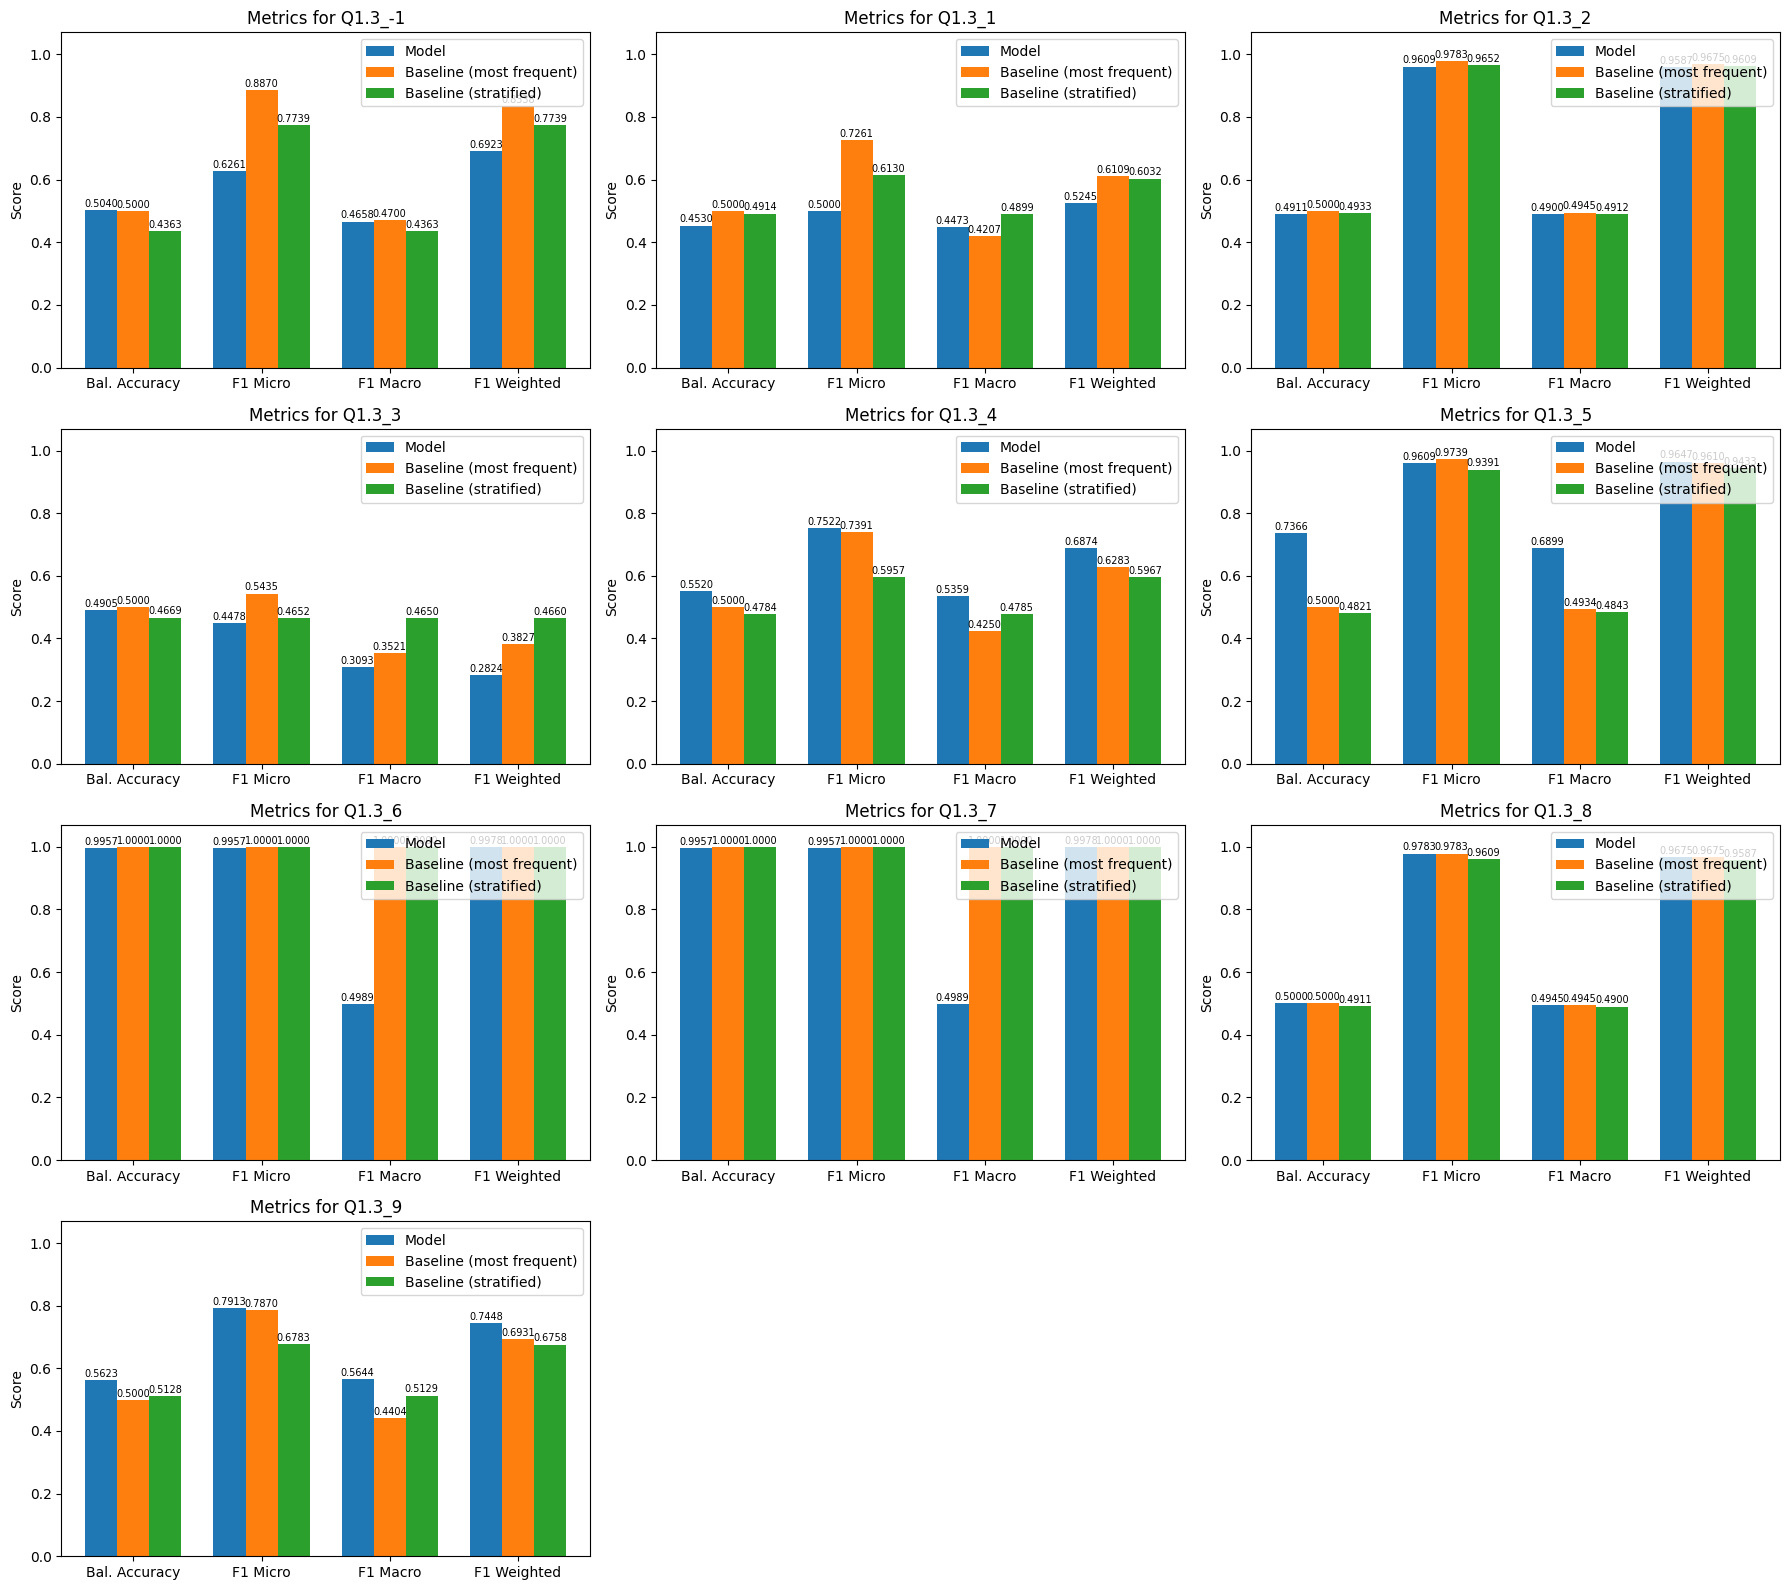

In [14]:
calculate_standard_metrics('Manuel', 'ChatGPT4AsAnnotator', df_1_3)


# Q 1.3.1

## Questions

### Original

Q1.3.1: If the headline contains a quotation, does that same quotation appear in the content of the story? (Check one):<br>
    1.  No<br>
    2.  Yes<br>
    -1. No quotation present<br>


### Reviseted

Step 10 - If the headline contains quoted text, does that same quoted text appear in the story's content? (Check one):<br>
    1.  No<br>
    2.  Yes<br>
    -1. No quotation present


## Analisi

In [15]:
inter_annotator_agreement(df, 'Q1.3.1', 'Manuel', 'Angelo')
inter_annotator_agreement(df, 'Q1.3.1', 'Manuel', 'Marinella')
inter_annotator_agreement(df, 'Q1.3.1', 'Angelo', 'Marinella')
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.3.1', 'Manuel', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.3.1', 'Marinella', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.3.1', 'Angelo', 'ChatGPT4AsAnnotator')


Kappa tra Manuel e Angelo per Q1.3.1: 0.6666666666666667
Kappa tra Manuel e Marinella per Q1.3.1: 0.47058823529411764
Kappa tra Angelo e Marinella per Q1.3.1: 0.8163265306122449
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.3.1: 0.0
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.3.1: 0.0
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.3.1: 0.0


# Q 1.4

## Questions

### Original

Q1.4: Does the article begin with a fact-based lead? (Check one):<br>
    1.  No<br>
    2.  Yes<br>


### Revisited

Step 11 - Does the first sentence of the text of this article clearly summarize the main fact that a news article is about by answering the where, when, how, and why of the fact described?<br><br>
No<br>
Yes<br>


## Analisi

### K

In [16]:
inter_annotator_agreement(df, 'Q1.4', 'Manuel', 'Angelo')
inter_annotator_agreement(df, 'Q1.4', 'Manuel', 'Marinella')
inter_annotator_agreement(df, 'Q1.4', 'Angelo', 'Marinella')
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.4', 'Manuel', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.4', 'Marinella', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.4', 'Angelo', 'ChatGPT4AsAnnotator')


Kappa tra Manuel e Angelo per Q1.4: 0.3913118427857266
Kappa tra Manuel e Marinella per Q1.4: 0.5313475177304965
Kappa tra Angelo e Marinella per Q1.4: 0.3157894736842105
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.4: 0.36450913595540424
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.4: 0.10825827089822382
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.4: 0.14751582582006517


In [17]:
inter_annotator_agreement(df, 'Q1.4', 'Manuel', 'Angelo')
inter_annotator_agreement(df, 'Q1.4', 'Manuel', 'Marinella')
inter_annotator_agreement(df, 'Q1.4', 'Angelo', 'Marinella')
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.4', 'Manuel', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.4', 'Marinella', 'ChatGPT4AsAnnotator')
inter_annotator_agreement(df, 'Q1.4', 'Angelo', 'ChatGPT4AsAnnotator')

Kappa tra Manuel e Angelo per Q1.4: 0.3913118427857266
Kappa tra Manuel e Marinella per Q1.4: 0.5313475177304965
Kappa tra Angelo e Marinella per Q1.4: 0.3157894736842105
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.4: 0.36450913595540424
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.4: 0.10825827089822382
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.4: 0.14751582582006517


# Q 1.5

## Questions

### Original

Q1.5 Please rate the degree of bias in the article copy (Check one):<br>
    1.  Extremely biased<br>
    2.  Mostly biased<br>
    3.  Somewhat biased<br>
    4.  Entirely unbiased<br>


### Revisited

Step 12 - Please rate the degree of bias in the article copy:<br>
    1.  Extremely Biased<br>
    2.  Biased<br>
    3.  Partly biased<br>
    4.  Unbiased<br>


## Analisi

# Q 1.6

## Questions

### Original

Q1.6 Does the article use sensationalised language? (Check one):<br>
    1.  Extremely sensationalised<br>
    2.  Somewhat sensationalised<br>
    3.  Mainly neutral<br>
    4.  Entirely neutral<br>


### Reviseted

Step 13 - Does the article use sensationalized language?:<br>
    1.  Extremely sensationalised<br>
    2.  Sensationalised<br>
    3.  Partly neutral<br>
    4.  Neutral<br>


## Analisi

# Q 1.7

## Questions

### Original

Q1.7: Does this story negatively target a specific group or individual? (Check one):<br>
    1.  No<br>
    2.  Yes<br>


### Reviseted

Step 14 - Does this story negatively target a specific group or individual?:<br>
    1.  No<br>
    2.  Yes<br>


## Analisi

# Q 1.7.1

## Questions

### Original

Q1.7.1: If the answer 1.7 is yes, please specify the group or individual negatively target. (Check all that apply):<br>
0.  Conservatives<br>
1.  Liberals<br>
2.  Gender<br>
3.  LGBTQ<br>
4.  Immigrants<br>
5.  Jews/Judaism<br>
6.  Islam/Muslims<br>
7.  Christians/Christianity<br>
8.  Religion (Other)<br>
9.  Race/ethnicity<br>
10.  Reputation (Organisation)<br>
11.  Reputation (Person)<br>
12.  Other<br>


### Reviseted

Step 15 - Specify the group or individual negatively targeted. Specify for each option "Yes" if the element appears in the title, "No" oyherwise):<br>
    0.  Political<br>
    1.  Religion<br>
    2.  Race/ethnicity<br>
    3.  Orientation<br>
    4.  The article negatively targets other groups or minorities<br>


## Analisi

In [20]:
df['Q1.7.1'].unique()

array(['-1', '3', '4', '0', '1', '1;3', '4;3', '2', '4;1', '4;2;3', '2;3',
       '2;4', '0;4', '0;2', '1;4'], dtype=object)

### Creo colonne singole per ciascun valore possibile nella colonna e salvo in un nuovo dataframe

In [21]:
# Dividi la colonna 'Q1.3' in colonne separate
df_split = df['Q1.7.1'].str.get_dummies(sep=';')

# Rinomina le colonne con i valori unici
df_split.columns = ['Q1.7.1_' + col for col in df_split.columns]

# Unisci il dataframe diviso con il dataframe originale
df_1_7_1 = pd.concat([df, df_split], axis=1)

# Mostra il dataframe risultante
df_1_7_1 = df_1_7_1.loc[:, ['id','annotator','Q1.7.1_-1','Q1.7.1_1','Q1.7.1_2','Q1.7.1_3','Q1.7.1_4']]

df_1_7_1

,id,annotator,Q1.7.1_-1,Q1.7.1_1,Q1.7.1_2,Q1.7.1_3,Q1.7.1_4
0,18d71db7-f362-46fa-953e-d8353c7f7232,Manuel,1,0,0,0,0
1,18d71db7-f362-46fa-953e-d8353c7f7232,Angelo,1,0,0,0,0
2,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Manuel,1,0,0,0,0
3,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Marinella,1,0,0,0,0
4,34b92f4c-32db-454c-a369-ca2032443f6c,Manuel,1,0,0,0,0
...,...,...,...,...,...,...,...
1014,3696bc79-2f24-47e2-9f13-fabd92b7a271,ChatGPT4AsAnnotator,1,0,0,0,0
1015,89ca8966-8ade-49fd-a036-c528a1f7871c,ChatGPT4AsAnnotator,0,0,0,0,0
1016,a425710b-96e3-4840-87be-75deea62775d,ChatGPT4AsAnnotator,1,0,0,0,0
1017,df86ebbe-1672-4c99-8895-b0fe742ed00c,ChatGPT4AsAnnotator,0,0,0,0,1


### Faccio la balanced accuracy

<Figure size 640x480 with 0 Axes>

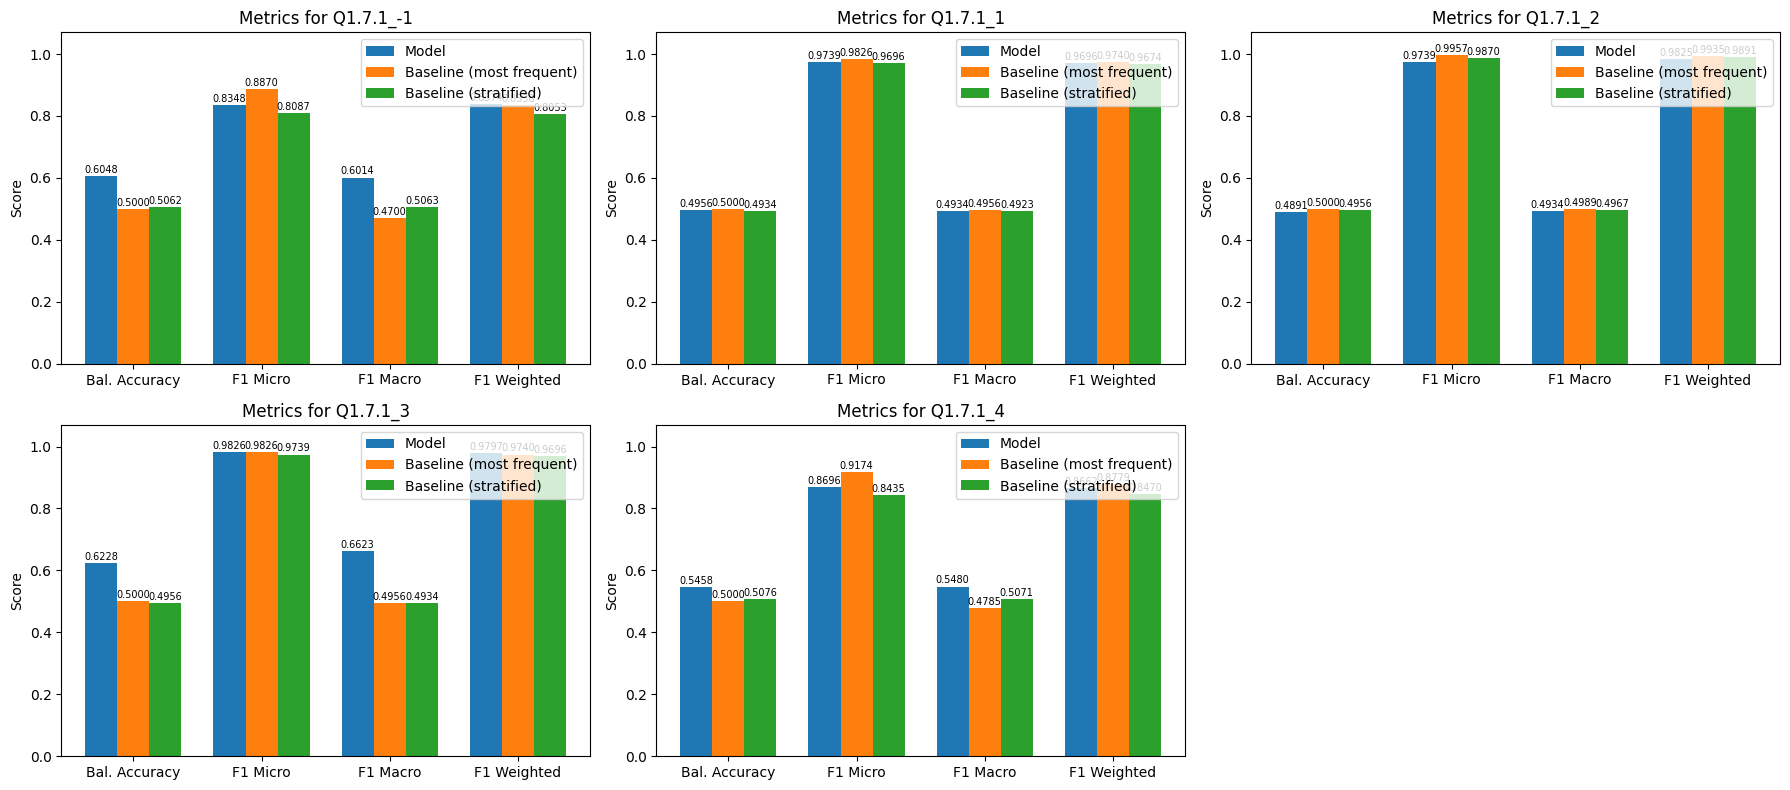

In [23]:
calculate_standard_metrics('Manuel', 'ChatGPT4AsAnnotator', df_1_7_1)


# Confusion Matrix

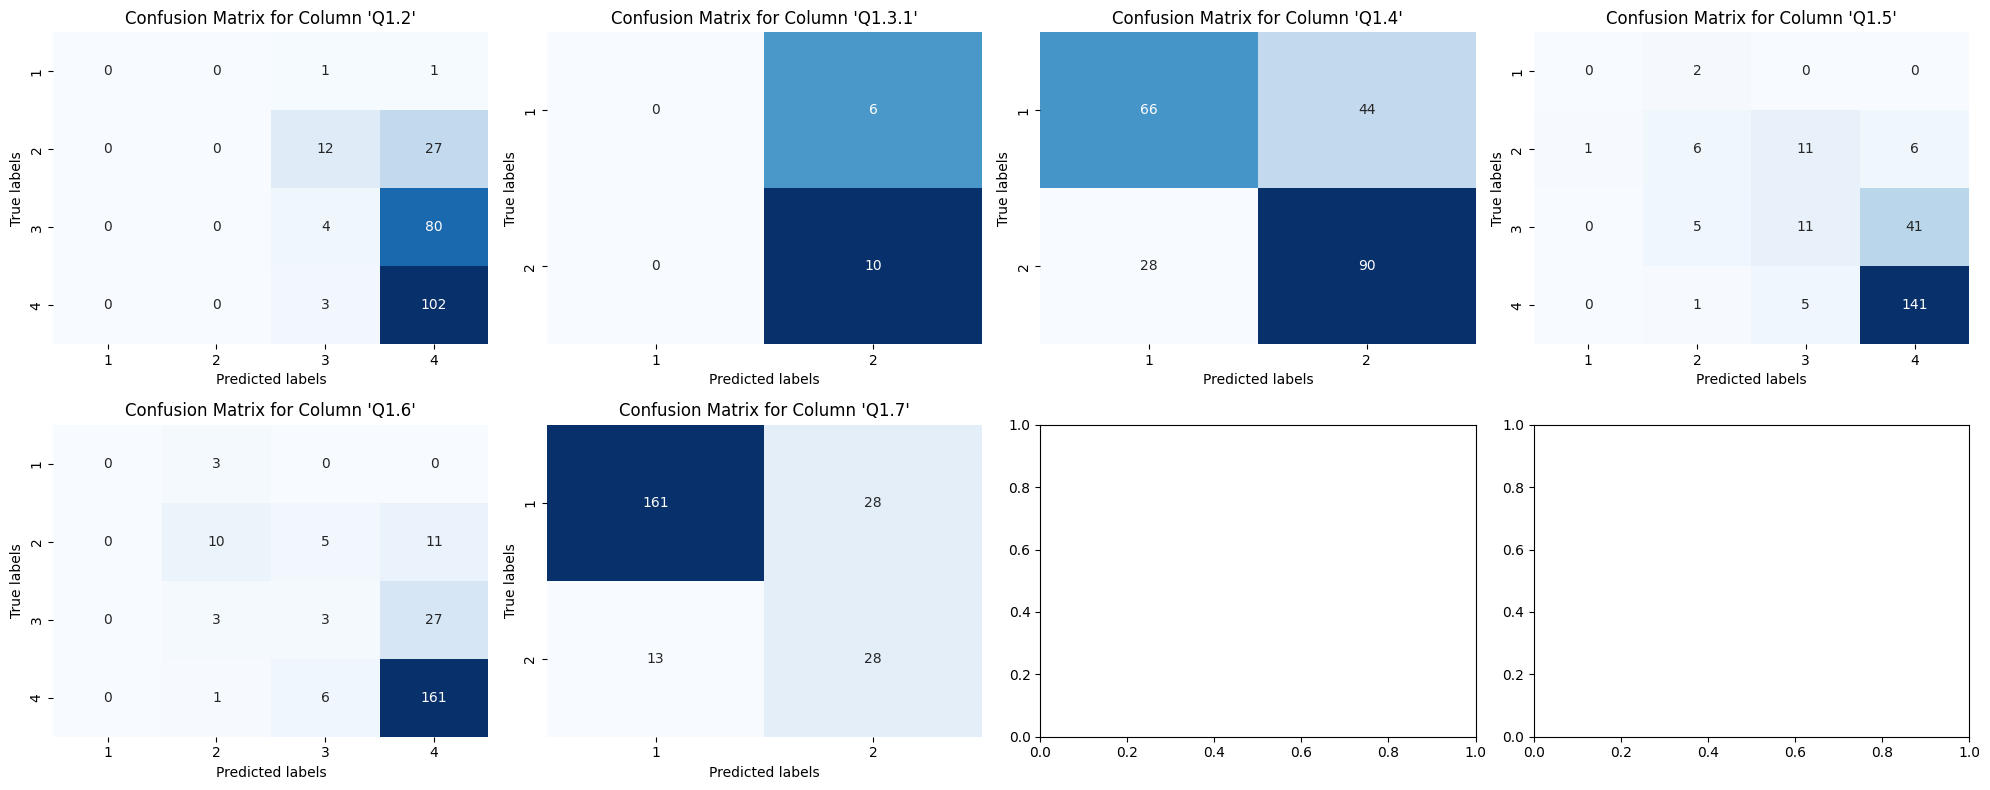

In [19]:
conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)

#conf_matrices = calculate_confusion_matrix('Marinella','ChatGPT4AsAnnotator', columns_to_consider, possible_values)

#conf_matrices = calculate_confusion_matrix('Fabio','ChatGPT4AsAnnotator', columns_to_consider, possible_values)